# Setup: Generate Sample Dataset
Sparsh Patel 08/20/2025

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [145]:
import os
os.chdir('/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7')
print(os.getcwd())

/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7


## Original data generation code, not used 
- This data gives us a near perfect correlation between the two datasets, which is not good for our regression analysis. So I have tweaked the code in order to make the two datasets feel quite apart.

In [ ]:
# import os
# import numpy as np
# import pandas as pd

# # Define folder paths relative to this notebook
# raw_dir = '/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7/data/raw'
# processed_dir = '/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7/data/processed'

# # Create folders if they don't exist
# os.makedirs(raw_dir, exist_ok=True)
# os.makedirs(processed_dir, exist_ok=True)

# # Generate business day dates
# dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# # Fixed random seed for reproducibility
# np.random.seed(7264)

# # Column 1: daily_return ~ N(0, 0.01)
# returns = np.random.normal(0, 0.01, size=len(dates))
# mask_pre_may = dates < "2022-05-01"
# returns[mask_pre_may] -= 0.0015  

# # Inject "shock" values
# shock_values = {
#     "2022-05-02": 0.1748425237194541,
#     "2022-05-03": -0.16825801732486943,
#     "2022-05-06": -0.19667220757153227,
#     "2022-05-09": 0.21240223590614747,
#     "2022-05-12": -0.178729287231294
# }
# for d, v in shock_values.items():
#     idx = np.where(dates == pd.to_datetime(d))[0][0]
#     returns[idx] = v

# # Column 2: daily_return_2, correlated with daily_return + small noise
# daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# # Create DataFrame with two numeric columns
# df = pd.DataFrame({
#     "date": dates,
#     "daily_return": returns,
#     "daily_return_2": daily_return_2
# })

# # Save to CSV in raw data folder
# csv_path = os.path.join(raw_dir, 'outliers_homework_original.csv')
# if not os.path.exists(csv_path):
#     df.to_csv(csv_path, index=False)
#     print(f'Synthetic dataset with two columns created and saved to {csv_path}')
# else:
#     print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

## Updated random generation logic to get bet better regression outputs
- Here I have injected outliers only to one of the columns in order to break the correlation between the two columns

In [147]:
import os
import numpy as np
import pandas as pd


raw_dir = '/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7/data/raw'
processed_dir = '/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7/data/processed'


os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)


dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")


np.random.seed(74)


returns = np.random.normal(0, 0.01, size=len(dates))

# Column 2: Strongly correlated with daily_return + small noise
# True relationship: daily_return_2 ≈ 0.9 * daily_return
daily_return_2 = 0.9 * returns + np.random.normal(0, 0.002, size=len(dates))

# Inject outliers ONLY in daily_return to "break" correlation
outlier_idx = np.random.choice(len(dates), size=8, replace=False)
returns[outlier_idx] += np.random.choice([0.15, -0.15, 0.2, -0.2], size=8)


df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')


Synthetic dataset created and saved to /Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7/data/raw/outliers_homework.csv


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [148]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(7264)

## Load Data (provided or synthetic fallback)

In [149]:
data_path = Path('/Users/sparshpatel/bootcamp_sparsh_patel/homework/homework7/data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.006083,0.006021
1,2022-01-04,-0.006367,-0.005485
2,2022-01-05,-0.004089,-0.003654
3,2022-01-06,0.008525,0.007817
4,2022-01-07,0.007375,0.005903


The fallback is not use in my case as I have generated my own data above beforehand. 

## TODO: Implement Outlier Functions 

In [150]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

### Implementing winsorizing 

In [151]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags 
- Chose the daily return 2 to detect and mark outliers of

In [152]:
target_col = 'daily_return_2' if 'daily_return_2' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged

outlier_iqr    0.017391
outlier_z      0.008696
dtype: float64

### Visual Checks (boxplot / histogram)

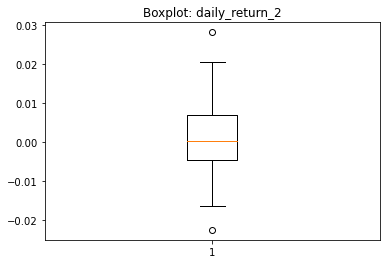

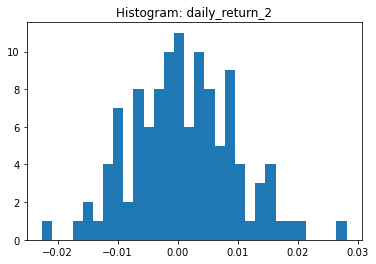

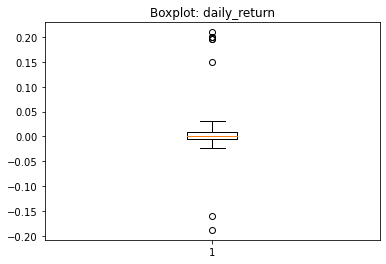

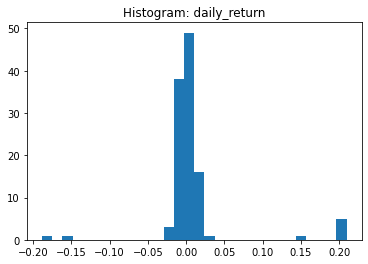

In [153]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

plt.figure()
plt.boxplot(df['daily_return'])
plt.title(f'Boxplot: daily_return')
plt.show()

plt.figure()
plt.hist(df['daily_return'], bins=30)
plt.title(f'Histogram: daily_return')
plt.show()

Here we come to know that:
- Daily return 2 is generalised and has values that look normally distributed
- Daily return column is densely populated around a small range with a few extreme outliers

## Sensitivity Analysis
Performed both summary stats and simple linear regression comparing **all vs. filtered** 

### Summary Stats

In [ ]:

summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,0.001023,0.000992,0.001084
median,0.000356,0.000356,0.000356
std,0.008659,0.008049,0.007755


### Simple regression

In [ ]:

if 'daily_return' in df.columns:
    # --- Raw data ---
    X_all = df[['daily_return']].to_numpy()
    y_all = df[target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))

    # --- IQR-filtered ---
    mask = ~df['outlier_iqr']
    X_flt = df.loc[mask, ['daily_return']].to_numpy()
    y_flt = df.loc[mask, target_col].to_numpy()

    model_flt = LinearRegression().fit(X_flt, y_flt)
    mae_flt = mean_absolute_error(y_flt, model_flt.predict(X_flt))

    # --- Winsorized ---
    X_win = winsorize_series(df['daily_return']).to_numpy().reshape(-1, 1)
    y_win = winsorize_series(df[target_col]).to_numpy()

    model_win = LinearRegression().fit(X_win, y_win)
    mae_win = mean_absolute_error(y_win, model_win.predict(X_win))

    # --- Collect results ---
    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0], model_win.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_, model_win.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_flt, y_flt), model_win.score(X_win, y_win)],
        'mae': [mae_all, mae_flt, mae_win]
    }, index=['all', 'filtered_iqr', 'winsorized'])

    print(results)

else:
    results = None
    print("No 'daily_return' column; skip regression or engineer features.")


                 slope  intercept        r2       mae
all           0.031638   0.000775  0.033588  0.006798
filtered_iqr  0.027082   0.000778  0.028844  0.006484
winsorized    0.225155   0.000144  0.247920  0.005453


### Reflection 
- Please go through the Readme file for proper documentation
